# Inclusion financière en Afrique

## 0. Préalable

### Importation des modules

In [1]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# models
from catboost import CatBoostClassifier
# tuning
from sklearn.model_selection import train_test_split
# encoding
from sklearn.preprocessing import OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler
# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import random
from datetime import datetime as dt

from joblib import Parallel, delayed
import joblib

In [2]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

### Chargement du jeu de données

In [3]:
DATA_PATH = 'data/' # repertoire des données
train_set = pd.read_csv(DATA_PATH + 'Train.csv') # ensemble d'apprentissage
test_set = pd.read_csv(DATA_PATH + 'Test.csv') # ensemble de test
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv') # exemple de soumission

In [4]:
train_set.head(4)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private


In [5]:
target = 'bank_account'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

La target de notre dataset est la variable **bank_account**.

Dimension du dataset

In [5]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train_set.shape)
print('Dimension du test set :', test_set.shape)

Dimension du train set : (23524, 13)
Dimension du test set : (10086, 12)


Types des variables

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


Analyse des variables qualitatives

In [7]:
train_set.select_dtypes(include='object').describe()

,country,uniqueid,bank_account,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524,23524,23524,23524,23524,23524,23524,23524,23524
unique,4,8735,2,2,2,2,6,5,6,10
top,Rwanda,uniqueid_1,No,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,4,20212,14343,17454,13877,12831,10749,12791,6437


In [8]:
for colonne in list(train_set.columns):
    print(colonne)
    print(train_set[colonne].value_counts(), '\n')

country
Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: country, dtype: int64 

year
2016    8735
2018    8169
2017    6620
Name: year, dtype: int64 

uniqueid
uniqueid_1       4
uniqueid_1413    4
uniqueid_1411    4
uniqueid_1410    4
uniqueid_1409    4
                ..
uniqueid_7318    1
uniqueid_7317    1
uniqueid_7316    1
uniqueid_7315    1
uniqueid_8759    1
Name: uniqueid, Length: 8735, dtype: int64 

bank_account
No     20212
Yes     3312
Name: bank_account, dtype: int64 

location_type
Rural    14343
Urban     9181
Name: location_type, dtype: int64 

cellphone_access
Yes    17454
No      6070
Name: cellphone_access, dtype: int64 

household_size
2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: household_size, dtype: int64 

age_of_respondent
30     1056
35      836
25      79

Analyse des variables quantitatives

In [9]:
train_set.select_dtypes(include='number').describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


Analyse des données manquantes

In [10]:
train_set.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

Super ! Notre dataset ne contient aucune donnée manquante.

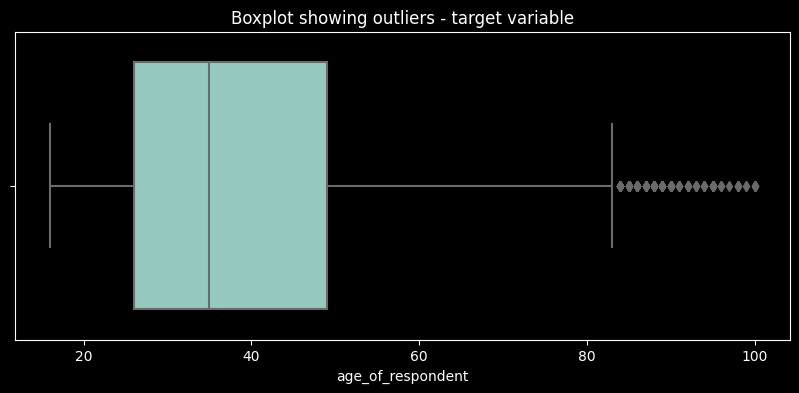

In [52]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_set['age_of_respondent'])
plt.title('Boxplot showing outliers - target variable')
plt.show()

Il n'y a aucun outlier dans ce dataset.

### 1.2. Analyse du fond

Analyse et visualisation de la target (bank_account)

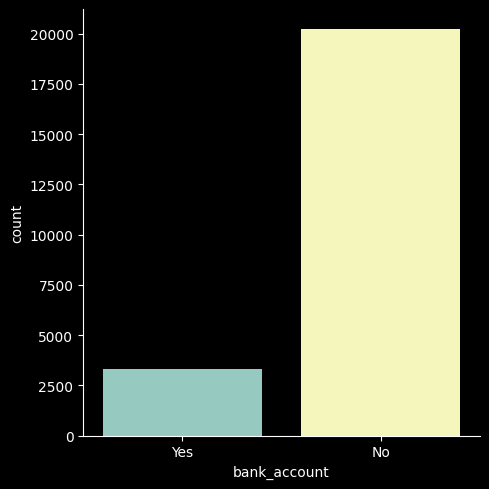

In [6]:
# explorons la distribution de la target
sns.catplot(data=train_set, x=target, kind='count')
plt.show()

Compréhension des diffiérentes variables

In [13]:
variables_definitions = pd.read_csv(DATA_PATH + 'VariableDefinitions.csv') # schema de definition des variables
variables_definitions

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


Matrice de corrélation de toutes les variables

<Axes: title={'center': 'Corrélation des features'}>

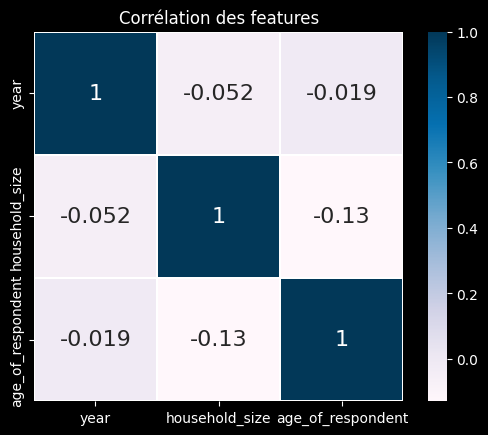

In [59]:
plt.title("Corrélation des features")
sns.heatmap(train_set.corr(numeric_only=True), linewidths=0.1, vmax=1.0, square=True, cmap=plt.cm.PuBu, linecolor="white", annot=True, annot_kws={"size": 16})

00 corrélation entre les variables du dataset

## 2. Pré-traitement

In [14]:
# Instantiating the scalers
MMS = MinMaxScaler()

### 2.1. Fonction réalisant le pré-traitement de notre dataset

In [29]:
def processing_dummy(data: pd.DataFrame) -> pd.DataFrame:
    ''' preprocessing d'un dataframe avec la méthode de dummification
    '''
    try:
        data_dummy = pd.get_dummies(
            data.drop(['uniqueid', 'bank_account'], axis=1))
        # normalisation
        scaler = MMS
        data_dummy[data_dummy.columns] = scaler.fit_transform(data_dummy)
        data_dummy['bank_account'] = data['bank_account']
    except:
        data_dummy = pd.get_dummies(data.drop(['uniqueid'], axis=1))
        # normalisation
        scaler = MMS
        data_dummy[data_dummy.columns] = scaler.fit_transform(data_dummy)
    try:
        # la liste des colonnes discrètes
        object_columns = list(
            data_dummy.select_dtypes(include='object').columns)
        # encodage des variables discrètes
        encoder = OrdinalEncoder()
        data_dummy[object_columns] = encoder.fit_transform(
            data_dummy[object_columns])
    except:
        pass
    return data_dummy


train_dummy = processing_dummy(train_set)
test_dummy = processing_dummy(test_set)


In [30]:
test_dummy.head()

,year,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,...,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,1.0,0.105263,0.166667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.315789,0.416667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.105263,0.726190,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.263158,0.273810,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.105263,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 2.2. Splitting pour l'entrainement

In [31]:
X_train_dummy = train_dummy.drop(['bank_account'], axis=1)
y_train_dummy = train_dummy['bank_account']
X_train_dummy.head()

,year,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,...,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,1.0,0.10,0.095238,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.20,0.642857,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.20,0.119048,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.20,0.214286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.35,0.119048,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Séparation des features et de la target

In [32]:
X_Train_dummy, X_Val_dummy, y_Train_dummy, y_Val_dummy = train_test_split(X_train_dummy, y_train_dummy, test_size = 0.1, random_state=12)

## 3. Modélisation

### 3.1. Entrainement et score

In [66]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'Logloss',
    'rsm': 0.7,
    'random_seed': SEED,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

model_dummy = CatBoostClassifier(**params)
model_dummy.fit(X_Train_dummy, y_Train_dummy, eval_set=[
                (X_Val_dummy, y_Val_dummy)], verbose=50)

y_model_dummy = model_dummy.predict(X_Val_dummy)
metrique = 1 - accuracy_score(y_Val_dummy, y_model_dummy)
print(f"Taux d'erreur du {str(model_dummy)} : {metrique}")

0:	learn: 0.6007609	test: 0.6000447	best: 0.6000447 (0)	total: 10.4ms	remaining: 31.2s
50:	learn: 0.2743848	test: 0.2612727	best: 0.2612727 (50)	total: 458ms	remaining: 26.5s
100:	learn: 0.2647134	test: 0.2582489	best: 0.2582489 (100)	total: 911ms	remaining: 26.2s
150:	learn: 0.2566342	test: 0.2584554	best: 0.2580459 (140)	total: 1.41s	remaining: 26.5s
200:	learn: 0.2500581	test: 0.2609648	best: 0.2580459 (140)	total: 1.92s	remaining: 26.7s
250:	learn: 0.2442592	test: 0.2625673	best: 0.2580459 (140)	total: 2.41s	remaining: 26.4s
300:	learn: 0.2389451	test: 0.2645173	best: 0.2580459 (140)	total: 3.01s	remaining: 27s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2580458571
bestIteration = 140

Shrink model to first 141 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x000002514C1DFA60> : 0.10412239694007652


### 3.2. Matrice de confusion

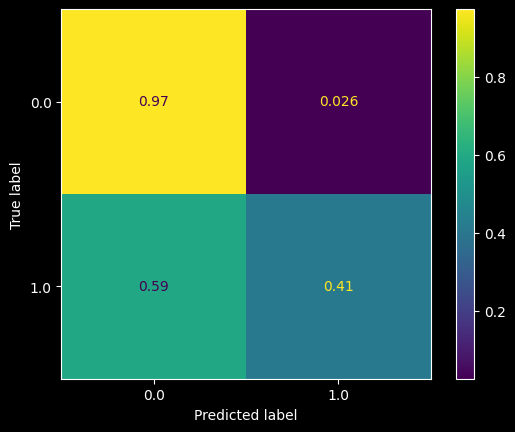

In [71]:
ConfusionMatrixDisplay.from_estimator(model_dummy, X_Val_dummy, y_Val_dummy, normalize='true')

Cette matrice montre que notre modèle reconnaît mieux les vrais négatifs (l'individu n'a pas de compte bancaire) par rapport aux vrais positifs (l'individu a un compte bancaire). Cela était prévisible car il y a 6 fois plus de négatifs que de positifs dans le dataset.

## 4. Prédiction

Après avoir choisi un modèle, réalisons maintenant les prédictions sur notre ensemble de test.

In [ ]:
try:
	test_dummy.drop(['bank_account'], axis=1, inplace=True)
except:
	pass

In [ ]:
test_set['bank_account'] = model_dummy.predict(test_dummy)
test_set.head(5)

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,1.0
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,1.0
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,0.0
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,0.0
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,0.0


## 5. Soumission

Visualisation du fichier d'exemple de soumission

In [ ]:
sample_submission.head()

Création de notre fichier de soumission

In [109]:
soumissions = pd.DataFrame(
    {"unique_id": test_set["uniqueid"] + " x " + test_set["country"], "bank_account": test_set['bank_account'].astype(int)})
soumissions.to_csv(
    f'submissions/soumission_{dt.now().strftime(format="%Y-%m-%d_%Hh%M")}.csv', index=False)
soumissions

## 6. Sauvegarde du modèle

In [43]:
# Save the model as a pickle in a file
# joblib.dump(model_dummy, 'models/catboost_dummy_0.108665476.pkl')

['models/catboost_dummy_0.108665476.pkl']